In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
ratings_df = pd.read_csv("/kaggle/input/anime-recommendations-database/rating.csv")
anime_df = pd.read_csv("/kaggle/input/anime-recommendations-database/anime.csv")

In [ ]:
print(ratings_df.describe())
print(ratings_df.head())
print(np.sum(ratings_df.isnull()*1))

In [ ]:
print(anime_df.describe())
print(anime_df.head())
print(np.sum(anime_df.isnull()*1))

# We will create an expilict recommender system which is based on the expicit past data in this case "ratings" given by the user for each movie.!!   

In [ ]:
import scipy.sparse as sparse
from implicit import nearest_neighbours as nn

## we will convert rating_df into a 2-dim matrix where rows are anime-id and columns are user-id, then it will be saved in a sparse format. Saving us compuatational time while fitting the model.

In [ ]:
sparse_item_user = sparse.csr_matrix(
    (ratings_df['rating'].astype(float),
     (ratings_df['anime_id'], ratings_df['user_id'])))



<p>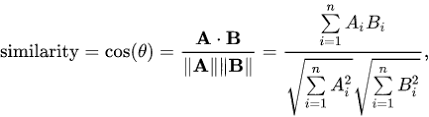</p>


#### Based on the cos distance of the two vectors. Our model will create a simmilarity score

In [ ]:
model = nn.CosineRecommender()

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')
model.fit(data_conf)

In [ ]:
item_id = ratings_df.anime_id.unique()

In [ ]:
item_similarity_dic = {}

for i in item_id:
    item_similarity_dic[i] = model.similar_items(i)[1:]


# cross-validating

In [ ]:
for x in item_id[:3]:
    info = anime_df[anime_df['anime_id']==x]
    print(f'Name of the show is, ***{info["name"].values[0]}*** and the Genre is -----> {info["genre"].values[0]}')
    for i,c in enumerate(item_similarity_dic[x]):
        if i > 2:
            break
        else:
            info = anime_df[anime_df['anime_id']==c[0]]
            print(f'similarity rank {i+1}')
            print(f'Name of the show is, ***{info["name"].values[0]}*** and the Genre is -----> {info["genre"].values[0]}')
    print("______________________________________________________________")


## Working Perfectly!! Lets build a recommender system. 

In [ ]:
user_watched_items = ratings_df.groupby('user_id')['anime_id'].apply(lambda g: g.values
                                                  .tolist()).to_dict()

In [ ]:
def merged_list(user_id):
    merge_list = {}
    for x in user_watched_items[user_id]:
        merge_list[x] = item_similarity_dic[x]
    
    return merge_list

In [ ]:
def top_recommendations(user_id,no_of_recommendation):
    merge_list = merged_list(user_id)
    t = list(merge_list.values())
    flat_list = [item for sublist in t for item in sublist]
    top_recommendations = pd.DataFrame(flat_list,columns=['item_id','sim_rating']).sort_values('sim_rating',ascending=False).head(no_of_recommendation).item_id.values
    
    return top_recommendations 
    
    

In [ ]:
import random

In [ ]:
for x in range(3):
    random_user = random.choice(ratings_df.user_id.unique())
    top_recomm = top_recommendations(2,5)
    print(f'userid : {random_user}')
    for i,c in enumerate(top_recomm):
        info = anime_df[anime_df['anime_id']==c]
        print(f'recommendation rank {i+1}')
        print(f'Name of the show is, ***{info["name"].values[0]}*** and the Genre is -----> {info["genre"].values[0]}')
    print("______________________________________________________________")


# Cheers!!!